# Data Madness 2022 - Is Thor worthy of a credit card/loan?

**Team:** Unofficial Data Scientists<br>
**Analyzing:** Credit Card Approval Prediction<br>
**From:** https://www.kaggle.com/rikdifos/credit-card-approval-prediction<br>
**Title:** Is Thor worthy of a credit card?<br>
**Objective of notebook:** would Thor we worthy enough to have a credit card/loan to his name? We aim at not only solving that hypthetical question, but also at understanding what would be the 'ideal' scenario in which you could get a credit card or loan (let's call them cc/l for short) approved (and also understand what can impact this scenario).

**We know you probably did not want to know about this. But, here we are. Sit tight and enjoy the ride** 

I always ask myself: how does each superhero come up with money. Boom! And like that, out of nowhere, they get money. I mean, come on. I know you are super smart, super fast, super strong and saving the world. But are you responsible? Seriously, they always have people cleaning their houses (and if they don't, it's a disaster). How do superheroes get the money they need to build their costumes/weapons/palaces?

In the MCU, how did Tony Stark manage to start his huge lucrative empire? Well, you may know that his father actually started it, so that's settled. What about the Vision? Well, he's a robot so he's a special case. What about Black Panther? Well, he is none other than the KING OF WAKANDA, so he doesn't need a loan, he owns the loan. And so we can go through a list of superheroes (from Marvel) until we reach a particular case that would be interesting to analyze: **_Thor_**.

Now, why Thor? Well, hear us out...


At the end of the movie "Thor: Ragnarok" you can see Thor and what is basically, the rest of Asgard, start their journey towards earth. This happens because of, you guessed it, Ragnarok (which is basically in Scandinavian mythology, the end of the world of gods and men). Everything goes well until, the mad titan himself, Mr. "Perfectly Balanced, as all things should be" Thanos, strikes them and basically kills the entire fleet.

Fast forward 5 years, the asgardians that survived are in earth with a fat Thor who is destroyed in Fortnite by NoobMaster69. But WAIT A MINUTE; how did they get the resources to build all of this? They must've brought some of their gold/money from Asgard, that would mean that they can pay directly with what they have to purchase the needed resources (and maybe get some in the process). BUT, let's assume (for the sake of this analysis) that they needed to ask a bank for a Loan so that they could make all the purchases they needed to do. Would it be granted? Well, most asgardians are a bunch of nobodies here on Earth. So that means that Thor must've asked for the loan himself. So (here it comes), would Thor be worthy of a credit card/loan? AHA! There it is! The moment you were waiting for. Isn't it very satisfying when you read the title of a book when you are going through it? Let this moment sink in for a little bit....................................................................


Before we begin, let's put on a suit and tie. We are now the bank that will asses Thor's capability to pay and compare him to other candidates we've had. Let's see if he will be a worthy (good) candidate for this. 

Ok, now what we actually came for... _analyzing the data._

In [121]:
#necessary imports (edit as you see fit)
import numpy as np

import os
import pandas as pd
import scipy as sc
import re
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype
from scipy import stats as st
from scipy.stats import norm
from sklearn import linear_model as lm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn.feature_selection import SelectKBest, chi2

from imblearn.over_sampling import SMOTE


import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Dropout
import keras.metrics 


from functools import reduce


app_record = pd.read_csv("YOUR FILEPATH HERE/application_record.csv")
credit_record = pd.read_csv("YOUR FILEPATH HERE/credit_record.csv")


Let's start by transforming our credit_record CVS so that we have unique values for each ID. Whilst doing this, we will
also define what a good and bad candidate will be. This will be neccesary for our model. First, let's check if we have any missing values in our dataset:

In [122]:
credit_record

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [123]:
missing_counts = len(credit_record.index) - credit_record.count()
missing_counts

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

Perfect! No missing data. Now, let's create a column for this new 'Good vs Bad' idea we have going on. Let's call it Status. Where **0** would be considered as _"Bad"_ and **1** _"Good"_.
Let's use a dictionary to properly identify what we will consider good and bad (and very bad) for every payment done. <br>

                                             'C' : 'Good_Behaviour'
                                             'X' : 'No_Loan'
                                             '0' : 'Good_Behaviour'
                                             '1' : 'Bad_Behaviour'
                                             '2' : 'Bad_Behaviour'
                                             '3' : 'Very_Bad_Behaviour'
                                             '4' : 'Very_Bad_Behaviour'    
                                             '5' : 'Very_Bad_Behaviour'
                                             
The formula below will automatically transform the data for us taking into consideration the following:<br>


If at least **20%** of the payments where of the _"Bad_Behaviour"_ category, mark it as **1**<br>
If at least **80%** of the data is _"No_Loan"_ then mark it as **1**. This is because someone that is **not** asking for money should not be considered a viable candidate as she/he would only generate work with and no profit for the bank (paperwork, etc).<br>
If the person had **at least 1** _"Very_Bad_Behaviour"_, then mark her/him as **1**.<br>
Everything else will be _"Good_Behaviour"_.

In [124]:
def credit_transform (data):
    
    """
    This formula converts all the payments from the credit record dataset into "Good vs Bad" dataset.
    """
    
    data['STATUS_TRANSF'] = data['STATUS']

    data = data.replace({'STATUS_TRANSF' :
                                            {'C' : 'Good_Behaviour',          # applicant already paid off this month
                                             'X' : 'No_Loan',                 # no loan this month
                                             '0' : 'Good_Behaviour',          # 1-29 days past due
                                             '1' : 'Bad_Behaviour',           # 30-59 days past due
                                             '2' : 'Bad_Behaviour',           # 60-89 days past due
                                             '3' : 'Bad_Behaviour',           # 90-119 days past due
                                             '4' : 'Very_Bad_Behaviour',           # 120-149 days past due
                                             '5' : 'Very_Bad_Behaviour'}})    # overdue or bad depts, write-offs for more than 150 days

    counts_per_id = data.value_counts(subset=['ID', 'STATUS_TRANSF']).unstack(fill_value=0)
    counts_per_id['Total_Payments'] = counts_per_id['Bad_Behaviour']+counts_per_id['Good_Behaviour']+counts_per_id['Very_Bad_Behaviour']+counts_per_id['No_Loan']
    counts_per_id.loc[((counts_per_id['Bad_Behaviour'])/counts_per_id['Total_Payments'] >= .20), 'Status'] = 0
    counts_per_id.loc[((counts_per_id['No_Loan'])/counts_per_id['Total_Payments'] >= .80), 'Status'] = 0
    counts_per_id.loc[(counts_per_id['Very_Bad_Behaviour'] > 0), 'Status'] = 0
    counts_per_id['Status'] = counts_per_id['Status'].fillna(value=1)
    counts_per_id['Status'] = counts_per_id['Status'].astype(int)
    status_count = pd.DataFrame(counts_per_id['Status'].value_counts())
    status_count.loc[[1,0],'Decision']='Good'
    status_count.loc[[0,0],'Decision']='Bad'
    print(status_count)
    print("Total data", status_count['Status'].sum(axis=0))       
    return counts_per_id

credit_gvb = credit_transform(credit_record)
credit_gvb

   Status Decision
1   39376     Good
0    6609      Bad
Total data 45985


STATUS_TRANSF,Bad_Behaviour,Good_Behaviour,No_Loan,Very_Bad_Behaviour,Total_Payments,Status
ID,,,,,,
5001711,0,3,1,0,4,1
5001712,0,19,0,0,19,1
5001713,0,0,22,0,22,0
5001714,0,0,15,0,15,0
5001715,0,0,60,0,60,0
...,...,...,...,...,...,...
5150482,0,18,0,0,18,1
5150483,0,0,18,0,18,0
5150484,0,13,0,0,13,1


Bingo Bango! There it is, this is the data that we will use to properly train our model. Looks like (from the present data) we have a nice balance between good and bad payments. Now, let's see how this behaves when merging and combining with the application record dataset. For now, let's start with the basics...

In [125]:
print(credit_record.shape)
print(app_record.shape)
print(credit_gvb.shape)

(1048575, 4)
(438557, 18)
(45985, 6)


Let's review if the raw record data (credit_record) matches the transformed data (credit_gvb).<br>
Credit_vgb will now be our new "Credit Record"

In [126]:
credit_record = credit_record.groupby('ID').agg({'MONTHS_BALANCE' : 'max', 'STATUS' : 'first'})
assert credit_record.shape[0] == credit_gvb.shape[0]

**First, let's check if credit record holds any duplicated ID's from application record:<br>**

duplicate_id = app_record['ID'].value_counts()<br>
duplicate_id = pd.DataFrame(duplicate_id)<br>
duplicate_id.drop(duplicate_id.loc[duplicate_id['ID']==1].index, inplace=True)<br>
duplicate_id.reset_index(inplace=True)<br>
duplicate_id = duplicate_id.rename(columns={'ID':'Aprnz', 'index' : 'ID'})<br>
credit_record.merge(duplicate_id, on="ID", left_index=True, right_index=True)<br>

**Now, let's create our train data. First, we need to drop duplicated values from the application record. After that is done, we will merge the data from the credit record with application record. This will allow us to make proper use of the data when analyzing it. We will use ID's from credit record as index. This will ensure that we get only the ID's that exist in both application and credit record.**

app_record = app_record.drop_duplicates(subset ="ID", keep = False)<br>
train_data = app_record.merge(credit_gvb, on="ID", left_index=False, right_index=True)<br>


**After that, we need to separate the training data from application record (entire data set). This will make it so we can do proper predicting of the data (test).<br>**

unseen_data_raw1 = pd.merge(app_record, train_data, how='outer', indicator=True)<br>
unseen_data = unseen_data_raw1[unseen_data_raw1._merge != 'both']<br>
unseen_data = unseen_data.drop(['Bad_Debt', 'Good_Debt', 'Status', '_merge'], axis=1)<br>

**Now that we're done, let's create a pipeline:**

In [127]:
def dup_check (data1,data2):
    
    """
    Data 1 must be the Application Record Dataset
    Data 2 must be the Credit Record Dataset with good vs. bad identified
    
    This function is checking if the existence of duplicated values that are found in the application record is not evident
    in the credit record. This would mean that we would need to decide on what to do with the data from the
    credit record dataset that has values that are duplicated in the app data (cloned entries, typos, etc).
    
    """
    duplicate_id = data1['ID'].value_counts()
    duplicate_id = pd.DataFrame(duplicate_id)
    duplicate_id.drop(duplicate_id.loc[duplicate_id['ID']==1].index, inplace=True)
    duplicate_id.reset_index(inplace=True)
    duplicate_id = duplicate_id.rename(columns={'ID':'Aprnz', 'index' : 'ID'})
    data2 = data2.merge(duplicate_id, on="ID")
    
    print('If dataframe has values, it means that duplicates from application record are found in credit record')
    
    return data2

In [128]:
    def data_filtering (data1,data2):

        """
        Data 1 must be the Application Record Dataset
        Data 2 must be the Credit Record Dataset with good vs. bad identified

        """
        data1_beforedrop = data1.shape[0]
        data1 = data1.drop_duplicates(subset ="ID", keep = False)
        print("The number of columns dropped was", data1_beforedrop, "-", data1.shape[0], "=", data1_beforedrop-data1.shape[0])
        train_data = data1.merge(data2, on="ID")
        unseen_data_raw1 = pd.merge(data1, train_data, how='outer', indicator=True)
        unseen_data = unseen_data_raw1[unseen_data_raw1._merge != 'both']
        unseen_data = unseen_data.drop(['Bad_Behaviour', 'Good_Behaviour', 'Status', '_merge', 'No_Loan', 'Very_Bad_Behaviour', 'Total_Payments'], axis=1)

        print("Train data has the following shape:", train_data.shape)
        print("Unseen data has the following shape:", unseen_data.shape)
        print("The total amount of rows from both train and unseen is", train_data.shape[0]+unseen_data.shape[0], ".", "Applicaton record has", data1.shape[0], "rows.")

        return train_data, unseen_data

In [129]:
dup_check(app_record,credit_gvb)

If dataframe has values, it means that duplicates from application record are found in credit record


,ID,Bad_Behaviour,Good_Behaviour,No_Loan,Very_Bad_Behaviour,Total_Payments,Status,Aprnz


In [130]:
train_data, unseen_data = data_filtering(app_record,credit_gvb)

The number of columns dropped was 438557 - 438463 = 94
Train data has the following shape: (36457, 24)
Unseen data has the following shape: (402006, 18)
The total amount of rows from both train and unseen is 438463 . Applicaton record has 438463 rows.


Perfect! As we can see, looks like the application record had 47 duplicated rows. We will get rid of these as they are not part of the training data (to simplify our lives).

Train data has a total amount of 36457 rows. Remember, the formula that we created makes it so that only the data from the credit record that appears on application record will be created on this new dataframe. So, with that said, we can conclude that there are around 9k ID's that don't match from the credit record with the application record. Our formula also checks that our data makes sense by adding both train and test data. The result should be the entire data set of application record (after the drop of rows).

**Check point of our data before transforming!**

train_data.to_csv('Train Data Good')

Let's start by reseting the index. This has to be done because we have lots of spaces in between our index due to the merge that happened when going from credit record and application record into a usable data frame for training our model.

In [131]:
def index_reset (data):
    """
    This function will get rid of the ID column and make an index with proper order
    """
    
    data = data.reset_index()
    data.drop(['index'], inplace=True, axis=1)
    return data
    
train_data = index_reset(train_data)
train_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Bad_Behaviour,Good_Behaviour,No_Loan,Very_Bad_Behaviour,Total_Payments,Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,NaN,2.0,1,14,1,0,16,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,NaN,2.0,1,13,1,0,15,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Security staff,2.0,0,14,16,0,30,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,0,2,3,0,5,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,0,0,5,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Managers,2.0,0,0,8,4,12,0
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,1,Medicine staff,2.0,10,6,0,8,24,0
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,1,Medicine staff,2.0,10,15,0,8,33,0
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Sales staff,2.0,2,8,0,0,10,0


(36457, 24)

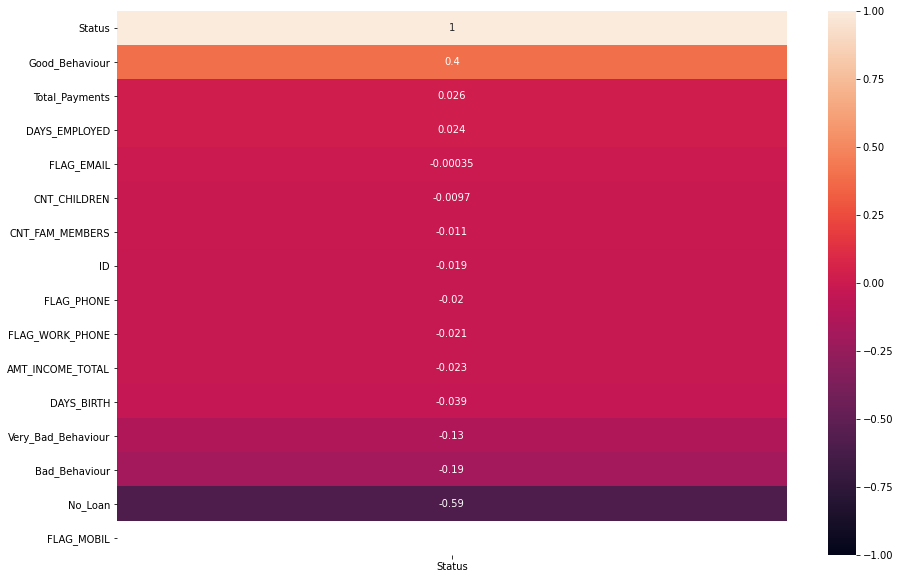

In [132]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr()[['Status']].sort_values(by='Status', ascending=False), vmin=-1,vmax=1, annot=True,cmap="rocket")
train_data.shape


In [133]:
def nan_check (data):
    
    """
    Formula used to check which columns have nan values
    """
  
    for column in data.columns:
        if data[column].isnull().values.any() == True:
            print(column, "column contains NaN values.")
            
nan_check(train_data)

OCCUPATION_TYPE column contains NaN values.


Let us see and analyze the data and let's look  for outliers in our data. We will use scatter plots and columns with continuous values to search for outliers:

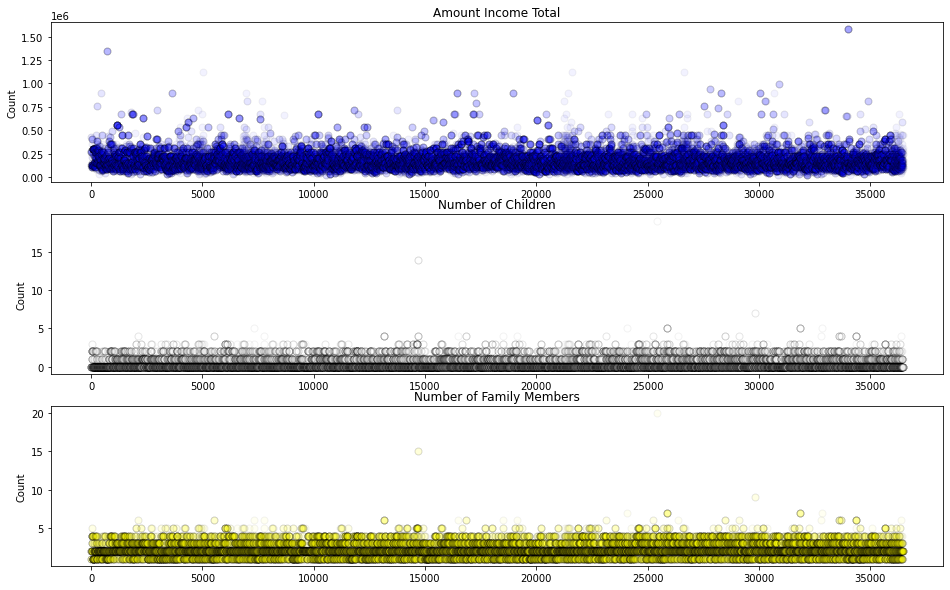

In [134]:
fig, ax = plt.subplots(3, figsize=(16, 10))

ax[0].plot(train_data['AMT_INCOME_TOTAL'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="blue", mec="black")
ax[0].set_title("Amount Income Total")
ax[0].set_ylabel("Count")

ax[1].plot(train_data['CNT_CHILDREN'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="white", mec="black")
ax[1].set_title("Number of Children")
ax[1].set_ylabel("Count")


ax[2].plot(train_data['CNT_FAM_MEMBERS'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="yellow", mec="black")
ax[2].set_title("Number of Family Members")
ax[2].set_ylabel("Count")

plt.show()

Looks like there are several data points that are way out of bounds when compared to the rest. For the purpose of training our model, it would be a good idea to get rid of these outliers and drop them entirely from our data. By doing this, we will make our model recognize the data better. Let's drop these outliers by identifying them via IQR.We will use the formula below:

In [135]:
def outlier_removal(data, column, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    data_old = data.shape[0]
    data = index_reset(data)
    data = data.loc[(data[column] > lower) & (data[column] < upper)]
    print("Rows dropped due to outliers for", column, " = ", data_old - data.shape[0])
    return data

#train_data = outlier_removal(train_data, 'AMT_INCOME_TOTAL', upper=600000)
#train_data = outlier_removal(train_data, 'CNT_CHILDREN', upper=6)    
#train_data = outlier_removal(train_data, 'CNT_FAM_MEMBERS', upper=6)

Perfect! Now, let's just check the last scaterplot again and make sure that these values are indeed no longer in our data:

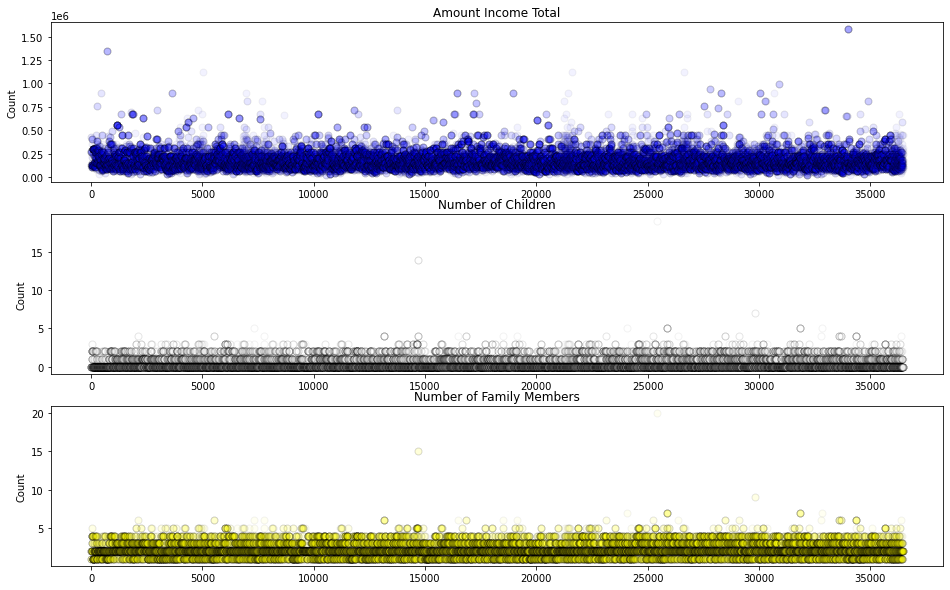

In [136]:
fig, ax = plt.subplots(3, figsize=(16, 10))

ax[0].plot(train_data['AMT_INCOME_TOTAL'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="blue", mec="black")
ax[0].set_title("Amount Income Total")
ax[0].set_ylabel("Count")

ax[1].plot(train_data['CNT_CHILDREN'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="white", mec="black")
ax[1].set_title("Number of Children")
ax[1].set_ylabel("Count")


ax[2].plot(train_data['CNT_FAM_MEMBERS'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="yellow", mec="black")
ax[2].set_title("Number of Family Members")
ax[2].set_ylabel("Count")

plt.show()

Going back to the Nan_check column, what's up with the OCCUPATION_TYPE column.
Let's investigate a little bit more about that specific column...

In [137]:
train_data['OCCUPATION_TYPE'].isna().sum()

11323

Looks like the data that is missing is simply uknown. Let us fill these NaN values and create a unique value called 'uknown'.

In [138]:
train_data['OCCUPATION_TYPE'] = train_data['OCCUPATION_TYPE'].fillna(value="Unknown")
train_data['OCCUPATION_TYPE'].value_counts()

Unknown                  11323
Laborers                  6211
Core staff                3591
Sales staff               3485
Managers                  3012
Drivers                   2138
High skill tech staff     1383
Accountants               1241
Medicine staff            1207
Cooking staff              655
Security staff             592
Cleaning staff             551
Private service staff      344
Low-skill Laborers         175
Waiters/barmen staff       174
Secretaries                151
HR staff                    85
Realty agents               79
IT staff                    60
Name: OCCUPATION_TYPE, dtype: int64

Oof! Looks like we have a bunch of **unknowns**. Before we do anything else with the column, let's analyze what we do have... 
Let's start by getting some basic descriptive statistics between the occupation and the annual income of the applicant.

In [139]:
def desc_stats_grouper (data, column1, column2):
    """
    Formula used to get some descriptive statistics of an indexed column (categorical) with another column (continuous)
    Data should be your initial data
    column1 should be your categorical data
    column2 should be your continuous data
    """
    
    occup_income_train = data[[column1, column2]]
    occup_income_mean = occup_income_train.groupby(column1).mean()
    occup_income_mean = occup_income_mean.rename(columns={column2:'Mean'})
    occup_income_median = occup_income_train.groupby(column1).median()
    occup_income_median = occup_income_median.rename(columns={column2:'Median'})
    occup_income_min = occup_income_train.groupby(column1).min()
    occup_income_min = occup_income_min.rename(columns={column2:'Min'})
    occup_income_max = occup_income_train.groupby(column1).max()
    occup_income_max = occup_income_max.rename(columns={column2:'Max'})
    occup_income_std = occup_income_train.groupby(column1).std()
    occup_income_std = occup_income_std.rename(columns={column2:'Std'})
    occup_income = [occup_income_mean, occup_income_median, occup_income_min, occup_income_max, occup_income_std]
    occup_income = pd.concat(occup_income, axis=1)
    return occup_income
    

In [140]:
occup_income = desc_stats_grouper(train_data, 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL')
occup_income

,Mean,Median,Min,Max,Std
OCCUPATION_TYPE,,,,,
Accountants,202463.865834,180000.0,45000.0,661500.0,104946.611731
Cleaning staff,149141.107078,135000.0,31500.0,450000.0,67772.783240
Cooking staff,146517.251908,135000.0,40500.0,495000.0,71223.962838
Core staff,190172.786967,166500.0,36000.0,990000.0,100864.352138
Drivers,209797.240412,202500.0,58500.0,900000.0,88854.415542
HR staff,193764.705882,157500.0,112500.0,675000.0,115849.465858
High skill tech staff,196053.579176,180000.0,54000.0,900000.0,92730.197916
IT staff,199860.000000,175500.0,103500.0,540000.0,93544.667478
Laborers,179794.282402,157500.0,36000.0,900000.0,73968.287897


In [141]:
def plot_sort (data):
    
    """
    Formula used to view the data in a sorted manner from the desc_stats_grouper function
    """
    meansort = data.sort_values(by=['Mean'])
    meansort = meansort['Mean']
    mediansort = data.sort_values(by=['Median'])
    mediansort = mediansort['Median']
    minsort = data.sort_values(by=['Min'])
    minsort = minsort['Min']
    maxsort = data.sort_values(by=['Max'])
    maxsort = maxsort['Max']
    stdsort = data.sort_values(by=['Std'])
    stdsort = stdsort['Std']

#Now, let's look at the data and see where unknown falls when sorting the values from lowest to highest.

    f, axs = plt.subplots(2,2,figsize=(14,14))

    plt.subplot(2, 3, 1)
    plt.plot(meansort)
    plt.xticks(rotation=90)
    plt.title("Mean")

    plt.subplot(2, 3, 2)
    plt.plot(mediansort)
    plt.xticks(rotation=90)
    plt.title("Median")

    plt.subplot(2, 3, 3)
    plt.plot(minsort)
    plt.xticks(rotation=90)
    plt.title("Min")

    plt.subplot(2, 3, 4)
    plt.plot(maxsort)
    plt.xticks(rotation=90)
    plt.title("Max")

    plt.subplot(2, 3, 5)
    plt.plot(stdsort)
    plt.xticks(rotation=90)
    plt.title("Std")

    plt.subplots_adjust(left=0.1, bottom=9, right=0.9, top=10, wspace=.25, hspace=.35)

    plt.show()



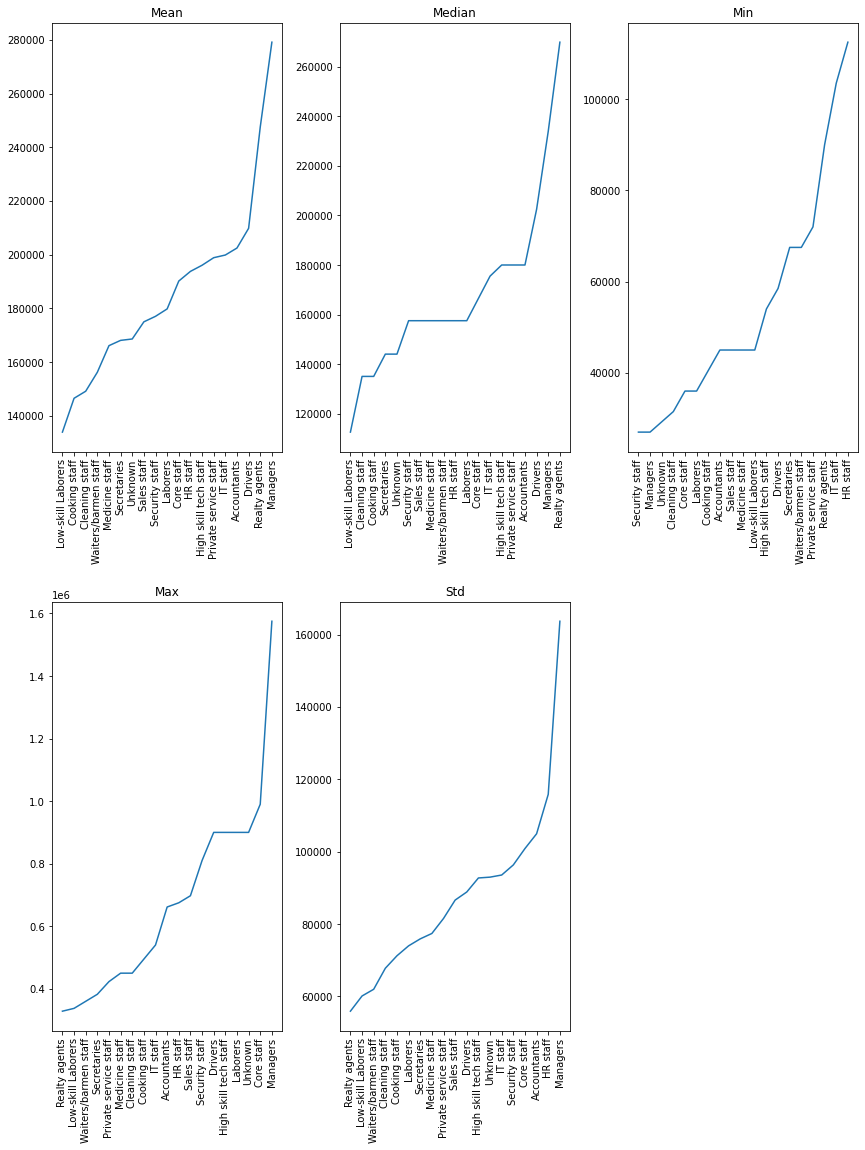

In [142]:
plot_sort(occup_income)

Upon futher investigation, we can clearly see that the Unknown value follow (to an extent) Security Staff and Secretaries occupancies.Becuase of this, we will drop this column.It doesn't seem to be offering any additional value and at least (in the training set we are working with) 20% of the data is missing.

Let's go back to the training data and one hot encode (OHE) the categorical values that we have on our training set. We will make sure to drop the OCCUPATION_TYPE column.

In [143]:
train_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Bad_Behaviour,Good_Behaviour,No_Loan,Very_Bad_Behaviour,Total_Payments,Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,Unknown,2.0,1,14,1,0,16,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,0,0,Unknown,2.0,1,13,1,0,15,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Security staff,2.0,0,14,16,0,30,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,0,2,3,0,5,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,1,Sales staff,1.0,0,0,5,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Managers,2.0,0,0,8,4,12,0
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,1,Medicine staff,2.0,10,6,0,8,24,0
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,1,Medicine staff,2.0,10,15,0,8,33,0
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,Sales staff,2.0,2,8,0,0,10,0


We will make a data frame that only contains the categorical data so that we can work with it specifically. But before that, we must replace the binary categorical data that we have. We will use .replace for this manner. We will also take this opportunity to drop the OCCUPANCY_TYPE column as it doesn't add value to our investigation.

Let's start by seeing what columns we have and, frome our codebook, check which ones are actually categorical.

In [144]:
train_data.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'Bad_Behaviour',
       'Good_Behaviour', 'No_Loan', 'Very_Bad_Behaviour', 'Total_Payments',
       'Status'],
      dtype='object')

In [145]:
train_data['CODE_GENDER'] = train_data['CODE_GENDER'].replace({'F':1, 'M':0})
train_data['FLAG_OWN_CAR'] = train_data['FLAG_OWN_CAR'].replace({'Y':1, 'N':0})
train_data['FLAG_OWN_REALTY'] = train_data['FLAG_OWN_REALTY'].replace({'Y':1, 'N':0})
train_data.drop("OCCUPATION_TYPE", axis=1, inplace=True)
train_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,Bad_Behaviour,Good_Behaviour,No_Loan,Very_Bad_Behaviour,Total_Payments,Status
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,2.0,1,14,1,0,16,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,0,0,2.0,1,13,1,0,15,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,2.0,0,14,16,0,30,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,1.0,0,2,3,0,5,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,0,1,1,1.0,0,0,5,0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,0,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,2.0,0,0,8,4,12,0
36453,5149834,1,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,0,1,1,2.0,10,6,0,8,24,0
36454,5149838,1,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,0,1,1,2.0,10,15,0,8,33,0
36455,5150049,1,0,1,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,2.0,2,8,0,0,10,0


In [146]:
#train_cat_data = train_data[['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]

In [147]:
def ohe_one_go (data):
    """
    Formula used to OHE all categorical-nonbinary columns
    The formula first separates the known categorical columns into its own dataframe
    It then used that data frame to do the OHE
    You should only use the data frame you wish to transform
    """
    train_cat_data = data[['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
    
    for column in train_cat_data.columns:
        cats_df = train_cat_data[column].value_counts()
        cats = cats_df.index
        cat_type = CategoricalDtype(categories=cats)
        train_cat_data[column] = train_cat_data[column].astype(cat_type)
        train_cat_data = pd.get_dummies(train_cat_data, prefix=column, columns=[column], drop_first=True)
    return train_cat_data
        

In [148]:
train_cat_data = ohe_one_go(train_data)

def ohe_merge (data1,data2):
    """
    This formula merges the created dataframe from the pge_one_go formula
    and merges it with the initial dataframe.
    Data 1 should be the initial dataframe
    Data 2 should be the dataframe from the ohe_one_go formula
    """
    
    data1.drop(['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'], inplace=True, axis=1)
    train_data_ohe = pd.concat([data1, data2], axis=1)
    return train_data_ohe

train_data_ohe = ohe_merge(train_data, train_cat_data)
train_data_ohe

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Co-op apartment
0,5008804,0,1,1,0,427500.0,-12005,-4542,1,1,...,0,0,1,0,0,0,0,1,0,0
1,5008805,0,1,1,0,427500.0,-12005,-4542,1,1,...,0,0,1,0,0,0,0,1,0,0
2,5008806,0,1,1,0,112500.0,-21474,-1134,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5008808,1,0,1,0,270000.0,-19110,-3051,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5008809,1,0,1,0,270000.0,-19110,-3051,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,0,1,1,0,315000.0,-17348,-2420,1,0,...,0,0,0,0,0,0,0,0,0,0
36453,5149834,1,0,1,0,157500.0,-12387,-1325,1,0,...,0,0,0,0,0,0,0,0,0,0
36454,5149838,1,0,1,0,157500.0,-12387,-1325,1,0,...,0,0,0,0,0,0,0,0,0,0
36455,5150049,1,0,1,0,283500.0,-17958,-655,1,0,...,0,0,0,0,0,0,0,0,0,0


Now that we did that, let's convert the data from DAYS_BIRTH and DAYS_EMPLOYED to some more managable data. We will say that every year has 365.25 days (according to this source https://www.britannica.com/science/time/Lengths-of-years-and-months). Also, the column DAYS_EMPLOYED has a positive number that gives us a value of more than 1000. This is done purposely to separate users that are pensionated. We will take this into consideration when creating a formula that checks for this. year value for those that are with the >1000 value will be 50 years.

In [149]:
def year_conversion (data):
    """
    This formula can be used to convert the 
    DAYS_EMPLOYED and DAYS_BIRTH columns into 
    YEAR_EMPLOYED and AGE_YEAR respectively.
    
    data should be your main dataframe
    """
    data['DAYS_BIRTH'] = round(data['DAYS_BIRTH']/-365,0)
    data.rename(columns={'DAYS_BIRTH':'AGE_YEARS'}, inplace=True)
    data['DAYS_EMPLOYED'].replace(365243, -18262.5, inplace=True)
    data['DAYS_EMPLOYED'] = abs(round(data['DAYS_EMPLOYED']/-365,0))
    data.rename(columns={'DAYS_EMPLOYED':'YEARS_EMPLOYED'}, inplace=True) 
    return data

year_conversion(train_data_ohe)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AGE_YEARS,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Co-op apartment
0,5008804,0,1,1,0,427500.0,33.0,12.0,1,1,...,0,0,1,0,0,0,0,1,0,0
1,5008805,0,1,1,0,427500.0,33.0,12.0,1,1,...,0,0,1,0,0,0,0,1,0,0
2,5008806,0,1,1,0,112500.0,59.0,3.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5008808,1,0,1,0,270000.0,52.0,8.0,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5008809,1,0,1,0,270000.0,52.0,8.0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,0,1,1,0,315000.0,48.0,7.0,1,0,...,0,0,0,0,0,0,0,0,0,0
36453,5149834,1,0,1,0,157500.0,34.0,4.0,1,0,...,0,0,0,0,0,0,0,0,0,0
36454,5149838,1,0,1,0,157500.0,34.0,4.0,1,0,...,0,0,0,0,0,0,0,0,0,0
36455,5150049,1,0,1,0,283500.0,49.0,2.0,1,0,...,0,0,0,0,0,0,0,0,0,0


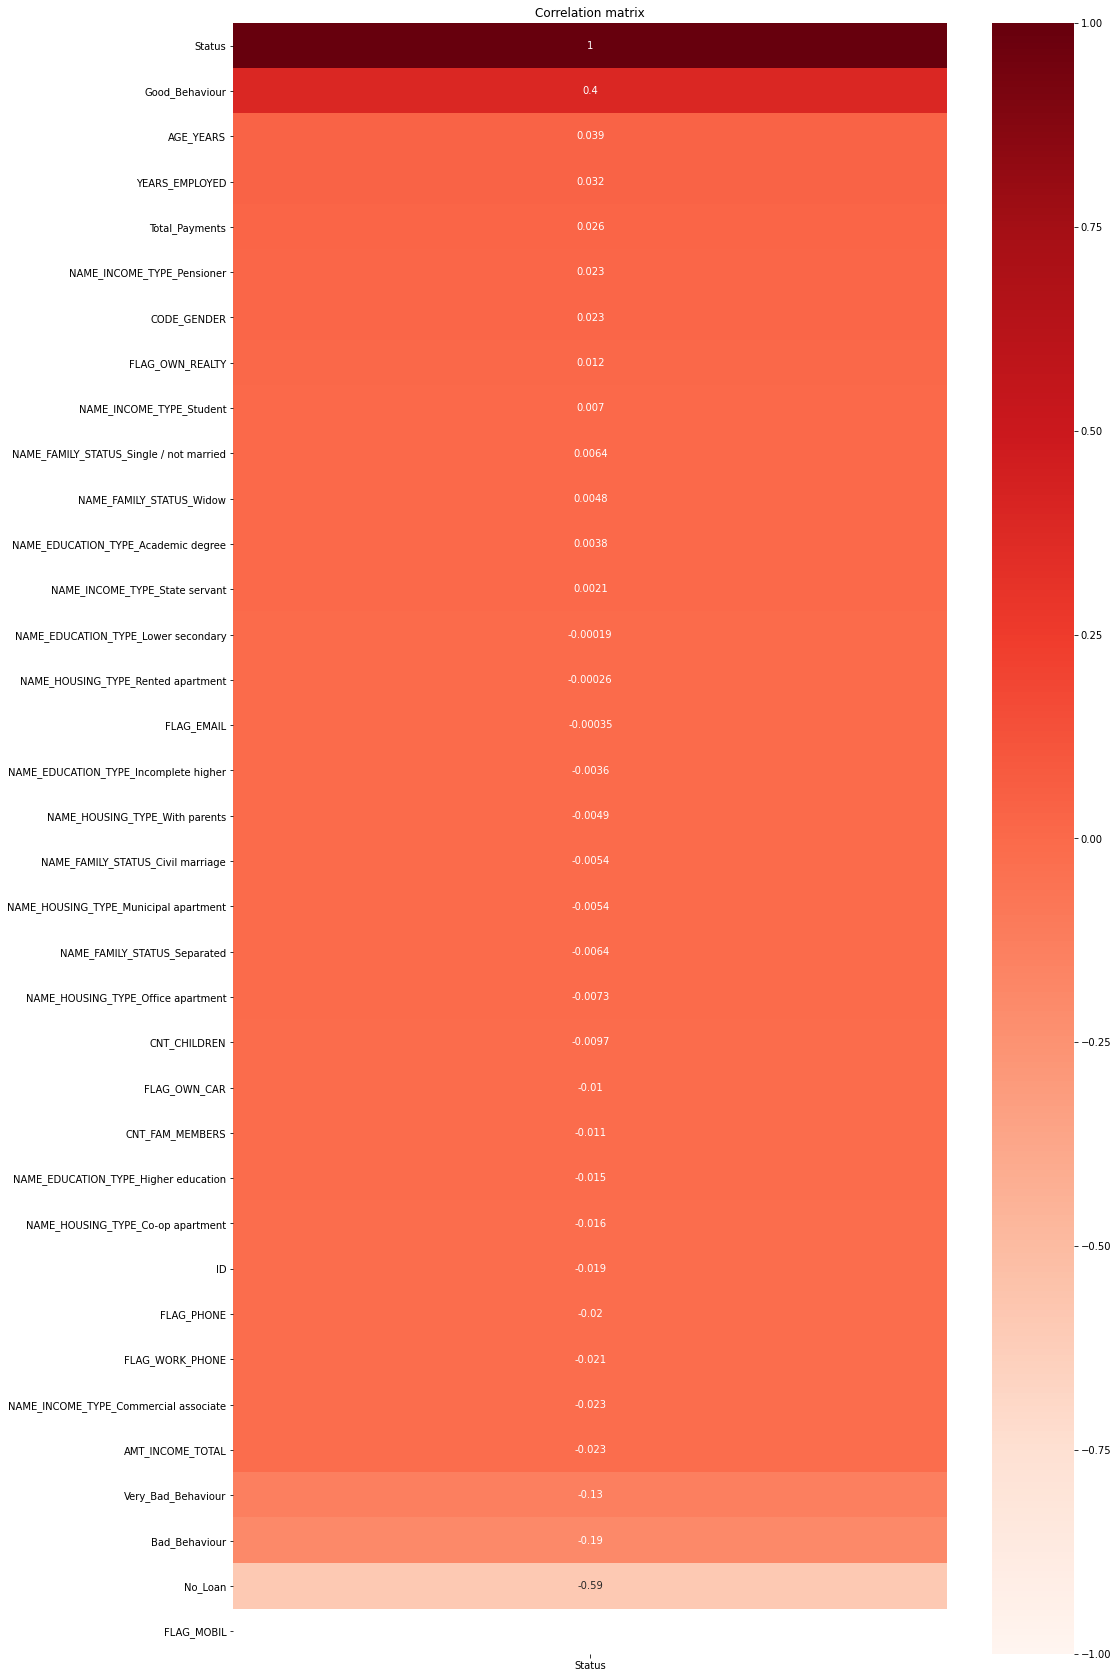

In [150]:
plt.figure(figsize=(16, 30))
sns.heatmap(train_data_ohe.corr()[['Status']].sort_values(by='Status', ascending=False), vmin=-1,vmax=1, annot=True,cmap="Reds")
plt.title("Correlation matrix")
plt.savefig("correlation_matrix.png")
plt.show()

Looking at these numbers, we can conclude that we are not doing this the right way. But hey, we gotta learn one way or another. Let's now look at the data in a different way....

#***Checkpoint for our data after transforming!***

train_data_ohe.to_csv('Train Data OHE')

In [151]:
train_data_ohe.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'Bad_Behaviour', 'Good_Behaviour', 'No_Loan', 'Very_Bad_Behaviour',
       'Total_Payments', 'Status', 'NAME_INCOME_TYPE_Commercial associate',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
       'NAME_INCOME_TYPE_Student', 'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_FAMILY_STATUS_Single / not married',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Rented apartment',
       'NAME_HOUSING_TYPE_Office apartment',
      

Next, we build some basic functions which we will use in the data pipeline to select columns for the model and standardize the continuous input features.

In [152]:
def standardize_columns(data):
    standardized_data = (data-data.mean())/data.std()
    return standardized_data

In [153]:
def select_columns(data, *columns):
    return data.reindex(columns = columns)

As the results of the correlation matrix showed, we end up in getting very small correlations between the potential input features and our target variable 'Status'.
This is because most of the variables in the dataset are categorical variables. Thus, we need run the Chi-Square test in order to get the relationship between our categorical input variables and the 'Status'.
Running the Chi-Square test with the Scikit-learn package gives us the P-Values of the independence between the variables.
Remember: The features with a P-Value smaller than 0.05 (independence threshold) show some relationship with the applicants' status. For features with a P-Value greater than 0.05, the null-hypothesis (variables are independent) holds true.

In [154]:
#Select the columns for the chi-square test:
nominal_features = select_columns(train_data_ohe, 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL',
                                                  'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'NAME_INCOME_TYPE_Commercial associate',
                                                  'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
                                                  'NAME_INCOME_TYPE_Student', 'NAME_EDUCATION_TYPE_Higher education',
                                                  'NAME_EDUCATION_TYPE_Incomplete higher',
                                                  'NAME_EDUCATION_TYPE_Lower secondary',
                                                  'NAME_EDUCATION_TYPE_Academic degree',
                                                  'NAME_FAMILY_STATUS_Single / not married',
                                                  'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated',
                                                  'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents',
                                                  'NAME_HOUSING_TYPE_Municipal apartment',
                                                  'NAME_HOUSING_TYPE_Rented apartment',
                                                  'NAME_HOUSING_TYPE_Office apartment',
                                                  'NAME_HOUSING_TYPE_Co-op apartment', 'Status',)

#Convert into NumPy-Arrays:
chi2_features = np.array(nominal_features)
status = np.array(nominal_features['Status'])
    
chi2_selector = SelectKBest(chi2, k='all')
chi2 = chi2_selector.fit(chi2_features, status)
chi2_pvals = chi2.pvalues_
    
chi2_pvals = pd.DataFrame(chi2_pvals)
columns = pd.DataFrame(nominal_features.columns)
frames = [columns, chi2_pvals]
chi2_data = pd.concat(frames, axis=1)

#Get the features with a p-value < 0.05:
feature_selection = chi2_data[chi2_data.iloc[:,1] < 0.05]
print("Categorical (nominal) variables with significance (p < 0.05): \n", feature_selection)

Categorical (nominal) variables with significance (p < 0.05): 
                                         0         0
0                             CODE_GENDER  0.013492
4                         FLAG_WORK_PHONE  0.000563
5                              FLAG_PHONE  0.001696
7   NAME_INCOME_TYPE_Commercial associate  0.000112
8              NAME_INCOME_TYPE_Pensioner  0.000045
11   NAME_EDUCATION_TYPE_Higher education  0.015862
23      NAME_HOUSING_TYPE_Co-op apartment  0.002131
24                                 Status  0.000000


Alright! We got data to work with. Now, we should define what Thor's entry would look like. According to the lore, Thor:
    
-Is Male<br>
-Doesn't have a car (he used to have a ship, it was destroyed by the mad titan before he arrived back to Earth)<br>
-Clearly doesn't have a property<br>
-Has no children<br>
-Has no income but he is severly rich <br>
-Might pensionated<br>
-Has no education but lots of experience. Let's assume he has Higher education completed.<br>
-Is single<br>
-Is a nomad (at the point of this examination [which is Avengers: Endgame]). But he did used to live with his parents<br>
-Is 1501 years (547865 days) old<br>
-Has been saving the world since 2011 (11 years employed)<br>
-Has no phone<br>
-Has no work phone<br>
-Has no email<br>
-Is a hero<br>
-Has Loki as his only family member who is **alive** (watch Loki to properly understand why he isn't counted as dead here)<br>

With the results from the chi squared test, we will now assign the correspondant values to the important columns.

In [155]:
thor_entry = pd.DataFrame({
                         'CODE_GENDER': [0], 
                         'FLAG_WORK_PHONE': [0],
                         'FLAG_PHONE': [0],
                         'NAME_INCOME_TYPE_Commercial associate': [0],
                         'NAME_INCOME_TYPE_Pensioner': [1],
                         'NAME_EDUCATION_TYPE_Higher education': [1],
                         'NAME_HOUSING_TYPE_Co-op apartment': [0],
                         'AMT_INCOME_TOTAL': [0],
                         'CNT_CHILDREN': [0],
                         'CNT_FAM_MEMBERS': [2],
                         'NAME_FAMILY_STATUS_Single / not married': [1],
                         'No_Loan': [1]})

In [156]:
#Declare names of subsets for use of boolean
train_data_ohe.name = 'training_data'
unseen_data.name = 'test_data'

Let's build the data pipeline we use for the pre-processing of both, the training data as well as the unseen test data withour the target column. In this pipeline, depending on if the training or unseen test data is loaded, we apply the proper processing. For the training set, this includes feature selection, outlier removal and the standardization of continuous features.

Since we have the problem of skewed data (unbalanced classes), we apply the SMOTE (Synthetic Minority Oversampling Technique) in order to synthesize data of the minority class. SMOTE works by selecting examples which are close in the feature space, drawing a line between the examples in the feature space and creating new datapoints along that line. After performing that, we have a balanced dataset which we can feed into the classifier model.


In [157]:
def pipe_func (data):

    if data.name == 'training_data':
        data = index_reset(data)
        
        #Select the columns we want to use for the model
        data = select_columns(data, 'CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                                    'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
                                    'NAME_EDUCATION_TYPE_Higher education', 'NAME_HOUSING_TYPE_Co-op apartment',
                                    'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS_Single / not married',
                                    'No_Loan', 'Status')

        #Remove outliers in the continuous data
        data = outlier_removal(data, 'AMT_INCOME_TOTAL')
        data = outlier_removal(data, 'CNT_CHILDREN')
        data = outlier_removal(data, 'CNT_FAM_MEMBERS')

        X = data.drop('Status', axis=1)
        cols_to_standardize = standardize_columns(X[['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']])

        #Standardize the continuous variables
        X['AMT_INCOME_TOTAL'] = cols_to_standardize['AMT_INCOME_TOTAL']
        X['CNT_CHILDREN'] = cols_to_standardize['CNT_CHILDREN']
        X['CNT_FAM_MEMBERS'] = cols_to_standardize['CNT_FAM_MEMBERS']
        
        y = data['Status']
        
        #Synthesize data of minority class and balance the dataset
        # -> SMOTE (Synthetic Minority Oversampling Technique)
        X_balance,y_balance = SMOTE().fit_resample(X,y)
        X_balance = pd.DataFrame(X_balance, columns = X.columns)
        
        print("X data shape after balancing: ", X_balance.shape)
        print("y data shape after balancing: ", y_balance.shape)

        #Split the training data into training and cross-validation
        X_train, X_cv, y_train, y_cv = train_test_split(X, y,
                                        test_size=0.2, random_state=42)

        return X_train, y_train, X_cv, y_cv

    elif data.name == "test_data":

        print("Shape of test data: ", data.shape)
        data = index_reset(data)

        data = select_columns(data, 'CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                                    'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
                                    'NAME_EDUCATION_TYPE_Higher education', 'NAME_HOUSING_TYPE_Co-op apartment',
                                    'AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS_Single / not married','No_Loan')
    
        X = data

        cols_to_standardize = standardize_columns(X['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS'])
        X['AMT_INCOME_TOTAL'] = cols_to_standardize['AMT_INCOME_TOTAL']
        X['CNT_CHILDREN'] = cols_to_standardize['CNT_CHILDREN']
        X['CNT_FAM_MEMBERS'] = cols_to_standardize['CNT_FAM_MEMBERS']

        X_test = X

        return X_test
    
X_train, y_train, X_cv, y_cv = pipe_func(train_data_ohe)
#X_test = process_data(test_data)
#print("Test data: ", X_test.shape)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_cv: ", X_cv.shape)
print("y_cv: ", y_cv.shape)

Rows dropped due to outliers for AMT_INCOME_TOTAL  =  0
Rows dropped due to outliers for CNT_CHILDREN  =  0
Rows dropped due to outliers for CNT_FAM_MEMBERS  =  0
X data shape after balancing:  (62822, 12)
y data shape after balancing:  (62822,)
X_train:  (29165, 12)
y_train:  (29165,)
X_cv:  (7292, 12)
y_cv:  (7292,)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(29165, 2) (29165,)
[1 1 1 ... 1 1 1]


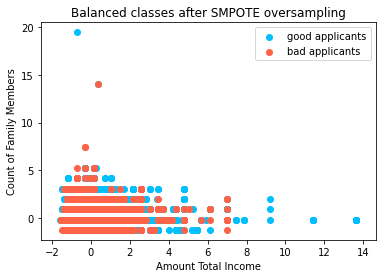

In [158]:
# Plot the data, color by class
X = np.array(X_train[['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS']])
y = np.array(y_train)

print(type(X), type(y)) 
print(np.shape(X), np.shape(y))
print(y)

plt.scatter(X[y == 1, 0], X[y == 1, 1], color="deepskyblue", marker="o",label="good applicants")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="tomato", marker="o",label="bad applicants")
plt.legend(scatterpoints=1)

x_min, x_max = X[:,0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Balanced classes after SMPOTE oversampling')
plt.xlabel('Amount Total Income')
plt.ylabel('Count of Family Members')
plt.savefig("balanced_classes.png")
plt.show()

Great! All the pre-processing is done and we can go into the modeling part...

In this model evaluation process we conducted different experiments with three types of classification model to see what works best.

1) Logistic Regression -> (see documentation here: https://towardsdatascience.com/introduction-to-logistic-   regression-66248243c148) 

2) Random Forest Classifier -> (see documentation here: https://towardsdatascience.com/understanding-random-forest-58381e0602d2) 

3) Neural Network for classification -> (see documentation here: https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839)
  

After defining the models, we will train on the training data and make predictions for the cross-validation data.

In [159]:
#Define the models we want to evaluate:
#model = LogisticRegression()
model = RandomForestClassifier()

num_features = X_train.shape[1]

'''
model = keras.Sequential([
layers.Dense(input_dim = num_features, units = 32, activation = "relu"),
#layers.Dense(units= 128, activation = "relu"),
#layers.Dropout(0.2),
layers.Dense(units= 64, activation = "relu"),
#layers.Dropout(0.2),
layers.Dense(units= 64, activation = "relu"),
#layers.Dropout(0.2),
#layers.Dense(units= 64, activation = "relu"),
layers.Dense(units= 32, activation = "relu"),
layers.Dense(units= 16, activation = "relu"),
#layers.Dropout(0.2),
layers.Dense(units=1, activation = "sigmoid")])
model.summary()

metrics = [
    tf.keras.metrics.Accuracy(name="Accuracy"),
    tf.keras.metrics.Precision(name="Precision"),
    tf.keras.metrics.Recall(name="Recall")]

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = metrics)
history = model.fit(X_train, y_train, validation_split=0.33, batch_size = 32, epochs = 50)
print("Evaluate on test data")
score_train = model.evaluate(X_train, y_train)
print("train loss, train accuracy, train precision, train recall:", score_train)
score_test = model.evaluate(X_cv, y_cv)
print("test loss, test accuracy, test precision, test recall:", score_test)

#Plot learning curve for accuracy:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.grid()
plt.savefig("NN_accuracy.png")
plt.show()
#Plot learning curve for precision:
plt.plot(history.history['Precision'])
plt.plot(history.history['val_Precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.grid()
plt.savefig("NN_precision.png")
plt.show()
#Plot learning curve for recall:
plt.plot(history.history['Recall'])
plt.plot(history.history['val_Recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'cv'], loc='upper left')
plt.grid()
plt.savefig("NN_recall.png")
plt.show()
'''

'\nmodel = keras.Sequential([\nlayers.Dense(input_dim = num_features, units = 32, activation = "relu"),\n#layers.Dense(units= 128, activation = "relu"),\n#layers.Dropout(0.2),\nlayers.Dense(units= 64, activation = "relu"),\n#layers.Dropout(0.2),\nlayers.Dense(units= 64, activation = "relu"),\n#layers.Dropout(0.2),\n#layers.Dense(units= 64, activation = "relu"),\nlayers.Dense(units= 32, activation = "relu"),\nlayers.Dense(units= 16, activation = "relu"),\n#layers.Dropout(0.2),\nlayers.Dense(units=1, activation = "sigmoid")])\nmodel.summary()\n\nmetrics = [\n    tf.keras.metrics.Accuracy(name="Accuracy"),\n    tf.keras.metrics.Precision(name="Precision"),\n    tf.keras.metrics.Recall(name="Recall")]\n\nmodel.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = metrics)\nhistory = model.fit(X_train, y_train, validation_split=0.33, batch_size = 32, epochs = 50)\nprint("Evaluate on test data")\nscore_train = model.evaluate(X_train, y_train)\nprint("train loss, train accuracy,

In [160]:
#Fit the model to the training data:
model.fit(X_train, y_train)

RandomForestClassifier()

In [161]:
#Make predictions on the cross-validation data in order to evaluate:
y_predict_cv = model.predict(X_cv)
y_predict_cv = np.array(y_predict_cv).astype(int)

Let's get to the final part and compute all the important metrics to look at. We evaluated the classification models with the following metrics:

- Precision
- Recall
- F1-Score
- Jaccard Similarity Score

In addition we use the Scikit-learn package to print the confusion matrix, the Area-Under-The-Curve score and finally plot the ROC-AUC-Curve of the chosen model.

Remember: The ROC-AUC-Curve is based on probability and shows, how good our model can distinguish between positive and negative classes.

In [162]:
#Model evaluation
import sklearn.metrics as mtrcs
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_cv = np.array(y_cv)

print('Evaluation metrics of chosen model (Random Forest Classifier):')
print('Confusion Matrix:')
print(mtrcs.confusion_matrix(y_true = y_cv, y_pred = y_predict_cv))

#print('Accuracy Score = ', mtrcs.accuracy_score(y_true = y_cv, y_pred = y_predict_cv))
print('Precision = ', mtrcs.precision_score(y_true = y_cv, y_pred = y_predict_cv))
print('Recall = ', mtrcs.recall_score(y_true = y_cv, y_pred = y_predict_cv))
print('F-score = ', mtrcs.f1_score(y_true = y_cv, y_pred = y_predict_cv))

print('Jaccard similarity score', mtrcs.jaccard_score(y_true = y_cv, y_pred = y_predict_cv))

#Compute metrics manually for double-checking:
positives = np.count_nonzero(y_cv)
pred_positives = np.count_nonzero(y_predict_cv)
negatives = len(y_cv)-positives
pred_negatives = len(y_predict_cv)-pred_positives

print("Positives: ", positives)
print("Negatives: ", negatives)
print("Predicted positives: ", pred_positives)
print("Predicted negatives: ", pred_negatives)

tp = np.sum(np.logical_and(y_predict_cv == 1, y_cv == 1))
tn = np.sum(np.logical_and(y_predict_cv == 0, y_cv == 0))
fp = np.sum(np.logical_and(y_predict_cv == 1, y_cv == 0))
fn = np.sum(np.logical_and(y_predict_cv == 0, y_cv == 1))

print("True Positives = ", tp)
print("True Negatives = ", tn)
print("False Positives = ", fp)
print("False Negatives = ", fn)

Evaluation metrics of chosen model (Random Forest Classifier):
Confusion Matrix:
[[ 614  426]
 [ 219 6033]]
Precision =  0.9340455178820251
Recall =  0.9649712092130518
F-score =  0.9492565494453622
Jaccard similarity score 0.9034141958670261
Positives:  6252
Negatives:  1040
Predicted positives:  6459
Predicted negatives:  833
True Positives =  6033
True Negatives =  614
False Positives =  426
False Negatives =  219


Final chosen model: Random Forest Classifier
Area under the ROC curve:  0.8963196392539003


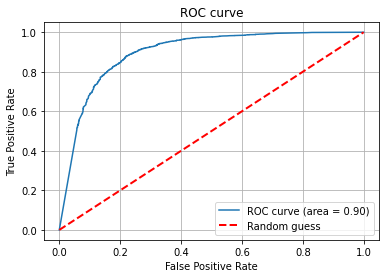

In [163]:
#ROC-AUC Curve
pred_proba = model.predict_proba(X_cv)
pred_proba = pred_proba[:,1]
fpr, tpr, thresh = mtrcs.roc_curve(y_cv, pred_proba)
auc = mtrcs.auc(fpr, tpr)

print("Final chosen model: Random Forest Classifier")
print("Area under the ROC curve: ", auc)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.savefig("roc_auc.png")
plt.show()


unseen_data.to_csv('Unseen Data OHE')

So, let's see what the model predicts for Thor. Is Thor a good applicant for getting a credit card?

In [164]:
thor_prediction = model.predict_proba(thor_entry)
print("Predicted probabilities for Thor: ", thor_prediction)

Predicted probabilities for Thor:  [[0.09083333 0.90916667]]


Seems, that with a pretty high certainty, the model classifies Thor as bad applicants...